# Drivers of Logerror

In [1]:
# reloads import files each time a cell is ran
%load_ext autoreload
%autoreload 2
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

import numpy as np
import scipy.stats as stats
import pandas as pd

from IPython.display import Video

# Visualizing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve

import modeling as md
import wrangle as wr
import exploration as exp
import acquire
import prepare
import split

alpha= 0.05
target_var = 'logerror'

## Project Overview

> * Discover drivers of logerror.
> * Use clustering to gain insights of subsets in our data.
> * Create a model to predict logerror (log(zestimate) - log(sale price))

### How:

> * Acquire and prepare data, explore visually and statistically and relate findings.

# Acquire Target Data
### Acquire Goal:

> * Acquire and save data for Single Family Homes that had a transaction in 2017
> * Add in elevation data using open-elevation API.
> * Added straight line distance from previously identified high-density areas

In [2]:
# load all data, and create train, validate, and test splits
train, validate, test, train_scaled, validate_scaled,\
test_scaled, scaler = wr.load_wrangle_zillow_with_elevation()
train.head()

,parcelid,bathroomcnt,bedroomcnt,sqr_ft,fullbathcnt,latitude,longitude,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,...,hypotenuse_dist_from_malibu,hypotenuse_dist_from_bel_air,hypotenuse_dist_balboa_island,hypotenuse_dist_laguna_beach,hypotenuse_dist_seal_beach,hypotenuse_dist_simi,hypotenuse_dist_ventura,hypotenuse_dist_channel_islands,hypotenuse_dist_ojai,hypotenuse_dist_eleanor
48081,11031387,3.0,4.0,2379.0,3.0,34.222798,-118.427490,10141.0,1925.0,157000.0,...,250.084599,247.391695,260.913244,265.005710,254.459042,249.197046,259.668632,10352.606619,259.351377,250.338619
27010,11023688,1.0,2.0,772.0,1.0,34.252212,-118.422645,7591.0,1946.0,84411.0,...,295.912744,293.504468,305.495191,309.057752,299.869480,294.864389,303.818880,10351.787270,303.341201,296.003940
24623,11056051,2.0,4.0,1609.0,2.0,34.255372,-118.492336,8252.0,1962.0,171023.0,...,281.410510,279.546840,293.320984,297.262934,287.007131,280.272512,288.628044,10346.660584,288.211661,281.330115
14340,14409471,3.0,3.0,2936.0,3.0,33.529421,-117.664988,28000.0,1981.0,295883.0,...,155.896642,141.520636,105.584464,103.615920,113.255564,167.362523,200.653229,10454.487067,205.536440,165.218529
44838,12915171,2.0,3.0,1008.0,2.0,34.100386,-117.914960,7212.0,1957.0,90922.0,...,168.364109,156.297335,157.791170,160.854848,154.265093,169.223083,196.146425,10393.409821,195.817204,171.665746


# Prepare
### Prepare Goals:

> * Clean data of any missing/null values and identify/correct any data that isn't helpful.
> * Split data into train, validate, and test sets for exploration and modeling.

Data was prepared in the same wrangle line that I used in the acquire step.

> * Outliers with z-score of greater than 3.5 were taken out.
> * Elevation data was added using the open-elevation API.
> * Data was formatted appropriately (lat/lon)
> * Null values were dropped, including rows where elevation could not be found. Reduced data from 52,000 to 49,000 rows.

### Initial Questions

> * Does elevation add any predictive value to our data?
Is elevation related to price per square foot?

> * Are there any clear subsets of features that make distinct classes in relation to logerror?

> * Does distance from previously identified hotspots have any relationship to logerror?




## Question 1: Does elevation add any predictive value to our data? Is elevation related to price per square foot?

### Latitude, longitude, Elevation by Price Per Square Foot.

In [3]:
Video("los_angeles_ppsft.mov", width=480, height=640)

### Takeaways

> * Elevation doesn't seem to have a large impact price per square foot, proximity to high populations seems to affect it more. Can test further.

## Hypothesis Testing:

**Null Hypothesis**: Elevation does not have a relation to price per square feet.

**Alternative Hypothesis**: Elevation ***does*** have a significant relation to price per square feet.

In [4]:
r, p = stats.pearsonr(train.elevation, train.pp_sqr_ft)
r,p

if p < alpha:
    print('We reject the null hypothesis that elevation does not have a signifcant relation to price per square inch.')
    print(f'r: {round(r, 2)}, p: {round(p, 2)}')
else:
    print('We fail to reject the null hypothesis that elevation does not have a significant relation to price per square inch.')
    print(r, p)

We reject the null hypothesis that elevation does not have a signifcant relation to price per square inch.
r: -0.18, p: 0.0


## Takeaway:

> * Elevation has a slight negative correlation to price per square inch. This could be to elevation being meaningful or it could be collinearity with cities with high value being closer to the coast(i.e. sea level).

## Question 2: Are there any clear subsets of features that make distinct classes in relation to logerror?


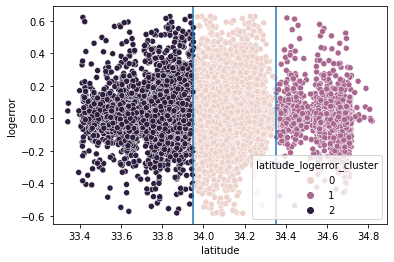

In [5]:
x = pd.DataFrame()
x['logerror_abs'] = abs(train['logerror'])
x = train[['latitude', 'longitude', 'elevation', 'logerror']].copy(deep=True)

x['lat_cat'] = wr.latitude_logerror(train)

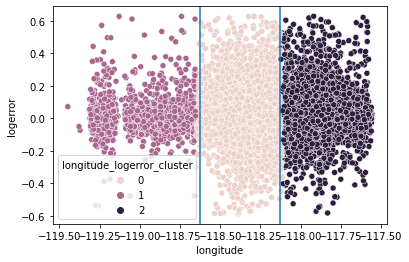

In [6]:
x['lon_cat'] = wr.longitude_logerror(train)

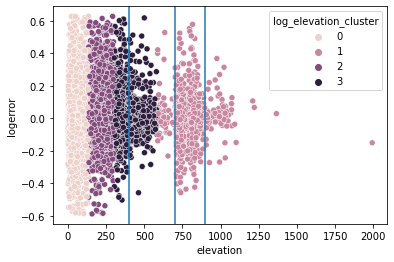

In [7]:
x['elevation_cat'] = wr.elevation_logerror(train)

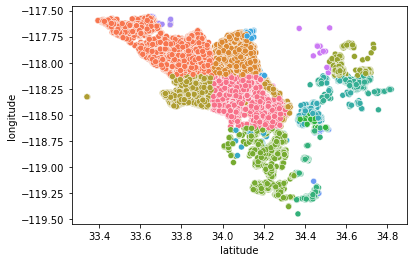

48081    middle_high_log | middle_high_log | low_elevat...
27010    middle_high_log | middle_high_log | low_elevat...
24623    middle_high_log | middle_high_log | low_elevat...
Name: combined_categories, dtype: object

In [14]:
x['combined_categories'] = x.apply(lambda x: x.lat_cat+" | "+ x.lon_cat + " | " + x.elevation_cat, axis=1)

sns.scatterplot(x=train.latitude, y=train.longitude,hue=x.combined_categories, legend=False)
plt.show()

x.combined_categories.head(3)

## Does the label make sense? Min and Max Mean Logerror (absolute) 

In [9]:
mean_log_by_category = {}

for cat in x.combined_categories.unique():
    absolute_log = abs(x[x.combined_categories==cat].logerror)
    mean_log_by_category[cat] = absolute_log.mean()
    
cat_mean_log_df = pd.DataFrame(mean_log_by_category, index=range(len(mean_log_by_category)))
df = cat_mean_log_df.T.rename(columns={0:'mean_log_error_abs'})
df.mean_log_error_abs[df.mean_log_error_abs==df.mean_log_error_abs.min()], \
df.mean_log_error_abs[df.mean_log_error_abs==df.mean_log_error_abs.max()]

(north_high_log east_high_log middle_elevation_low_log    0.02042
 Name: mean_log_error_abs, dtype: float64,
 north_high_log east_high_log high_elevation_high_log    0.103111
 Name: mean_log_error_abs, dtype: float64)

### Takeaway:

> * By categorizing sections of the data based on logerror variance, we can get a look at which sections are hard to estimate and which areas are easier to estimate.

> * Would like more time to explore these subsets.

### Question 3: Does distance from previously identified hotspots have a relation with logerror?

In [10]:
dist_cols = [x for x in train_scaled.columns if 'dist' in x]
dist_cols.insert(0,'logerror')
data = train[dist_cols].copy(deep=True)
data['logerror'] = train['logerror']
corr = data.corr()

corr.logerror

logerror                           1.000000
hypotenuse_dist_from_la           -0.007613
hypotenuse_dist_from_long_beach   -0.008175
hypotenuse_dist_santa_monica      -0.007304
hypotenuse_dist_from_malibu       -0.007630
hypotenuse_dist_from_bel_air      -0.007329
hypotenuse_dist_balboa_island     -0.009219
hypotenuse_dist_laguna_beach      -0.009652
hypotenuse_dist_seal_beach        -0.008422
hypotenuse_dist_simi              -0.007805
hypotenuse_dist_ventura           -0.008815
hypotenuse_dist_channel_islands    0.009784
hypotenuse_dist_ojai              -0.008850
hypotenuse_dist_eleanor           -0.007803
Name: logerror, dtype: float64

# Takeaway:

> * The relationship between distance from previously identified hotspots and logerror is nearly a non-factor, although when grouped together by county or other categories, might contribute a couple percent.

# Exploration Summary:

> * We made subsets of the data based on location and elevation, identifying different variations in logerror within these bands.
> * The linear relationship between distance to high density areas and logerror is weak/non-existant.
> * More time to explore the subsets could yield interesting insights, plenty of room to create more subsets.

# Model and Evaluate

### Modeling Goals:

> Construct a model to predict logerror for single family properties using regression techniques.

## Creating Baseline & Modeling

### Modeling Code

In [11]:
lm = LinearRegression(normalize=True)
target= 'logerror'

x_train = train_scaled.drop(columns=[target, 'index', 'parcelid'])
y_train = train_scaled[target]

#
x_validate = validate_scaled.drop(columns=[target, 'county', 'index', 'parcelid'])
y_validate = validate_scaled[target]


lm.fit(x_train, y_train)

# predict train
y_train_pred = lm.predict(x_train)
y_val_pred = lm.predict(x_validate)

#
y_train_pred = pd.DataFrame(y_train_pred)
y_val_pred = pd.DataFrame(y_val_pred)

y_train_pred['mean'] = y_train.mean()
y_val_pred['mean'] = y_validate.mean()


# evaluate: rmse
rmse_train = mean_squared_error(y_train, y_train_pred[0])**(1/2)
rmse_validate = mean_squared_error(y_validate, y_val_pred[0])**(1/2)


rmse_validate_baseline = mean_squared_error(y_validate, y_val_pred['mean']) **(1/2)
rmse_train_baseline = mean_squared_error(y_train, y_train_pred['mean'])**(1/2)


rmse_train, rmse_train_baseline,\
rmse_validate, rmse_validate_baseline

(0.09704081772124357,
 0.09743190036230182,
 0.09502790604140032,
 0.0950393860279724)

## Test Best Model

In [12]:
x_test = test_scaled.drop(columns=[target,'parcelid', 'index'])
y_test = test_scaled[target]

y_test_pred= pd.DataFrame(lm.predict(x_test))
y_test_pred['mean'] = y_test.mean()


rmse_test_baseline = mean_squared_error(y_test, y_test_pred['mean']) ** (1/2)
rmse_test = mean_squared_error(y_test, y_test_pred[0])

rmse_test, rmse_test_baseline


(0.009978152651033011, 0.10032261423377785)

## Modeling Takeaway:

> * There's been a signifcant improvement in our test set, doesn't seem correct and warrants exploring further.
> * Minimal improvements in train/validate, which I believe paints the real story. Not significant enough improvement to warrant implementation without exploring the data further.

# Conclusion

> * Essentially no variable had a large correlation with logerror that could help in the creation of a predictive model.
> * We are able to identify subsets of categories that can help us gain insight for our data, such as identifying which areas will be easier or more difficult to identify logerror.
> * The modeling process returned minimal or no improvements. Some of these subsets could be modeled to see if improvements can be made. With our current ML practices, it's unlikely that progress with modeling will be made without investing in changes to data acquistion.